# Lab 5. Sample Calculations

## Fluid Flow and Vane Interaction

This section focuses on jet flows from a nozzle and interactions with a vane, which can be either flat (plate) or curved (hemispherical).

The nozzle, with diameter $d$, directs the fluid flow onto the vane. The flow rate $Q$ measures how much fluid passes through the nozzle in a given time. It is critical for determining the speed of the fluid when it hits the vane.

- We calculate the mean velocity $u$ using the equation:

$$
u = \frac{4Q}{\pi d^2}
$$

- As the fluid strikes the vane, its velocity changes, resulting in a deflected velocity $u_0$, calculated by:

$$
u_0 = \sqrt{u^2 - 2gs}
$$

where $g$ is the gravitational acceleration and $s$ is the distance from the nozzle to the vane. 

- The momentum $J$ of the fluid is found using:

$$
J = \dot{m} \cdot u_0
$$

where $\dot{m}$ is the mass flow rate. This equation indicates the combined effect of the mass of the fluid and its velocity on the force exerted on the vane.

- Finally, the force $F$ acting on the vane is described by:

$$
F = \frac{M \cdot g \cdot (a + y)}{a}
$$

This force is crucial for understanding how the vane will respond to the incoming fluid flow, as it depends on the mass of the vane $M$, gravitational acceleration $g$, the distance $a$ from the pivot point to the vane, and $y$, the height of the fluid column.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Constants
rho = 1000 * 1e-09  # kg/mm^3
g = 9.81 * 1000     # mm/s^2
diameter = 10       # mm  nozzle diameter
s = 35              # mm distance between nozzle-vane
Mass = 600/1000    # (kg) the jockey mass
a = 150             # mm vane-pivot distance

# Data for the flat plate
# Group 4
y1 = np.array([102, 86, 68, 42, 19])  # mm
vol1 = np.array([2000, 2000, 2000, 2000, 2000])  # mL
t1 = np.array([[3.45, 3.31, 3.25],
                [3.93, 3.71, 3.74],
                [4.37, 4.36, 4.33],
                [5.21, 5.25, 5.20],
                [6.88, 6.90, 6.78]])  # seconds

# Data for the hemispherical cup
y2 = np.array([188, 140, 90, 50, 20])  
vol2 = np.array([2000, 2000, 2000, 2000, 2000])
t2 = np.array([[3.53, 3.55, 3.66],
                [3.78, 3.98, 4.18],
                [4.98, 4.75, 4.93],
                [6.68, 6.25, 6.58],
                [9.49, 9.36, 9.54]])

t1_mean = np.mean(t1, axis=1)  # Mean time for each measurement
t2_mean = np.mean(t2, axis=1)  # Mean time for each measurement
q1 = 60*(vol1/1000)/t1_mean
q2 = 60*(vol2/1000)/t2_mean

q1

array([35.96403596, 31.6344464 , 27.56508423, 22.98850575, 17.50972763])

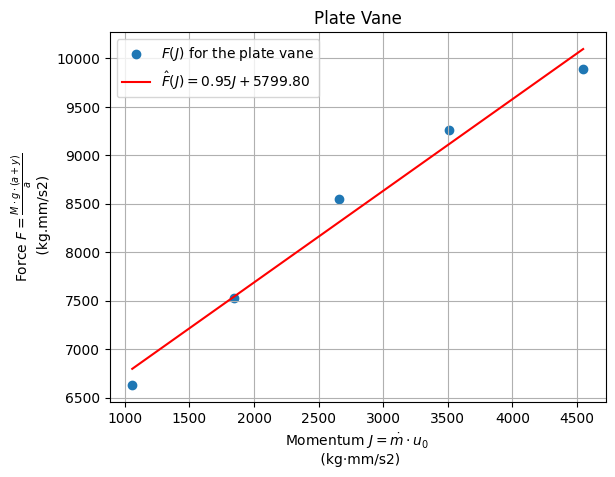


 - Results for Plate vane:
---------------------------------------------
  - The flow rates Q: [599401. 527241. 459418. 383142. 291829.] mm^3/s
  - The mass flow rates Qm: [0.599 0.527 0.459 0.383 0.292] kg/s
  - Mean Velocity u: [7632. 6713. 5849. 4878. 3716.] mm/s
  - Deflected Velocity u_0: [7587. 6662. 5790. 4807. 3622.] mm/s
  - Momentum J: [4547. 3512. 2660. 1842. 1057.] kg·mm/s^2
  - Force F: [9888. 9261. 8554. 7534. 6632.] kg.mm/s^2
  - Theoretical Force F: [10097.  9119.  8314.  7540.  6799.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 0.95
  - Linear Regression Intercept: 5.8e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.59 0.76 1.01 1.45 2.52]
---------------------------------------------




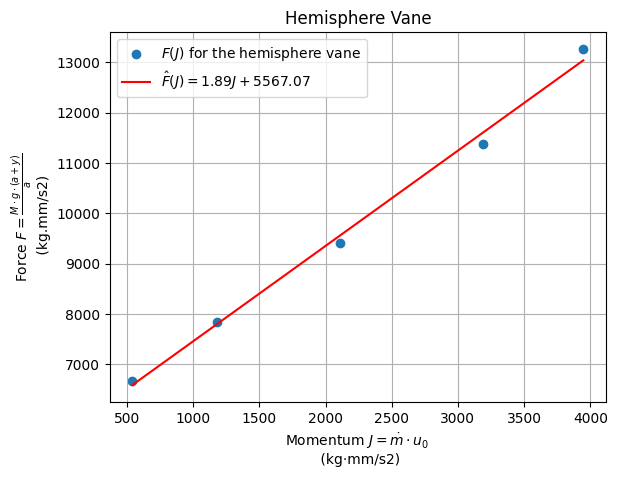


 - Results for Hemisphere vane:
---------------------------------------------
  - The flow rates Q: [558659. 502513. 409277. 307535. 211342.] mm^3/s
  - The mass flow rates Qm: [0.559 0.503 0.409 0.308 0.211] kg/s
  - Mean Velocity u: [7113. 6398. 5211. 3916. 2691.] mm/s
  - Deflected Velocity u_0: [7065. 6344. 5145. 3827. 2560.] mm/s
  - Momentum J: [3947. 3188. 2106. 1177.  541.] kg·mm/s^2
  - Force F: [13263. 11380.  9418.  7848.  6671.] kg.mm/s^2
  - Theoretical Force F: [13038. 11602.  9553.  7795.  6591.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 1.9
  - Linear Regression Intercept: 5.6e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.68 0.84 1.27 2.27 4.86]
---------------------------------------------




In [2]:
K_values = []
F_pred = []

# Computation
def solution(vol, time, y, plate="plate"):
    # Compute mean flow rates
    t_mean = np.mean(time, axis=1)  # Mean time for each measurement
    vol_mm3 = vol * 1e3              # Convert volume from mL to mm3
    q = vol_mm3 / t_mean               # mm^3/s

    # Mass flow rates
    m_dot = rho * q                   # kg/s

    # Velocity
    u = 4 * q / (np.pi * diameter**2)   # mm/s

    # Deflected velocity
    u_0 = [(i**2 - 2 * g * s)**0.5 for i in u]  # mm/s

    # velocity loss
    du = 100 * (u-u_0) / u

    # The delivery momentum
    J = m_dot * u_0

    # Force of the vane
    F = Mass * g * (a+y)/a

    # Fit a linear regression to F(J)
    model = LinearRegression()
    model.fit(J.reshape(-1, 1), F)  # Reshape J for sklearn
    K = model.coef_[0]  # Get the slope (K)
    intercept = model.intercept_  # Get the intercept

    K_values.append(K)  # Store the slope
    F_pred.append(model.predict(J.reshape(-1, 1)))  # Store predictions

    F_th = K * J + intercept
    
    # Let us plot F(J):
    plt.scatter(J, F, label=f"$F(J)$ for the {plate} vane")
    plt.plot(J, F_pred[-1], label=f"$\\hat{{F}}(J)={K:.2f}J+{intercept:.2f}$", color='red')
    plt.xlabel("Momentum $J=\\dot{m}\\cdot u_0$ \n (kg·mm/s2)")
    plt.ylabel("Force $F=\\frac{M\\cdot g \\cdot (a+y)}{a}$\n (kg.mm/s2)")
    plt.legend()
    plt.grid(True)
    plt.title(f"{plate.capitalize()} Vane")
    plt.show()

    # Print results with rounding
    print(f"\n - Results for {plate.capitalize()} vane:")
    print("---------------------------------------------")
    print(f"  - The flow rates Q: {np.round(q)} mm^3/s")
    print(f"  - The mass flow rates Qm: {np.round(m_dot,3)} kg/s")
    print(f"  - Mean Velocity u: {np.round(u)} mm/s")
    print(f"  - Deflected Velocity u_0: {np.round(u_0)} mm/s")
    print(f"  - Momentum J: {np.round(J)} kg·mm/s^2")
    print(f"  - Force F: {np.round(F)} kg.mm/s^2")
    print(f"  - Theoretical Force F: {np.round(F_th)} kg.mm/s^2")
    print("---------------------------------------------")
    print(f"  - Linear Regression Slope (K): {K:.2g}")
    print(f"  - Linear Regression Intercept: {intercept:.2g}")
    print("---------------------------------------------")
    print(f"  - Velocity Loss in percentage: {np.round(du,2)}")
    print("---------------------------------------------")
    print("\n")

# Execute the function for both configurations
solution(vol1, t1, y1, plate="plate")
solution(vol2, t2, y2, plate="hemisphere")

In [28]:
def solution_us_customary(vol, time, y, plate="plate"):
    # Compute mean flow rates
    t_mean = np.mean(time, axis=1)  # Mean time for each measurement
    vol_mm3 = vol * 1e3              # Convert volume from mL to mm3
    q = vol_mm3 / t_mean               # mm^3/s
    q_cfs = q * 3.53147e-8             # Convert mm^3/s to cfs

    # Mass flow rates in g/s
    m_dot_g = rho * q                 # g/s
    m_dot_lb = m_dot_g * 0.00220462   # Convert to lb/s

    # Velocity in mm/s and ft/s
    u_mm_s = 4 * q / (np.pi * diameter**2)  # mm/s
    u_ft_s = u_mm_s * 0.00328084            # ft/s

    # Deflected velocity in mm/s and ft/s
    u_0_mm_s = [(i**2 - 2 * g * s)**0.5 for i in u_mm_s]  # mm/s
    u_0_ft_s = [vel * 0.00328084 for vel in u_0_mm_s]      # ft/s

    # Velocity loss
    du = 100 * (u_mm_s - u_0_mm_s) / u_mm_s

    # Delivery momentum in kg·mm/s and lb·ft/s
    J_kg_mm_s = m_dot_g * u_0_mm_s
    J_lb_ft_s = [momentum * 0.00723301 for momentum in J_kg_mm_s]  # Convert to lb·ft/s

    # Force of the vane in kg·mm/s² and lb·ft/s²
    F_kg_mm_s2 = Mass * g * (a + y) / a
    F_lb_ft_s2 = F_kg_mm_s2 * 0.00723301  # Convert to lb·ft/s²

    # Fit a linear regression to F_th vs F
    model = LinearRegression()
    model.fit(F_lb_ft_s2.reshape(-1, 1), J_lb_ft_s)  # Fit F_th vs. F
    K = model.coef_[0]  # Get the slope (K)
    intercept = model.intercept_  # Get the intercept

    K_values.append(K)  # Store the slope
    F_pred.append(model.predict(F_lb_ft_s2.reshape(-1, 1)))  # Store predictions

    # Plotting F vs F_th in U.S. customary units
    plt.scatter(F_lb_ft_s2, J_lb_ft_s, label=f"$F(J)$ for the {plate} vane")
    plt.plot(F_lb_ft_s2, F_pred[-1], label=f"$\\hat{{F}}(J)={K:.2f}J+{intercept:.2f}$", color='red')
    plt.xlabel("Momentum $J=\\dot{m}\\cdot u_0$ \n (lb·ft/s)")
    plt.ylabel("Force $F=\\frac{M\\cdot g \\cdot (a+y)}{a}$\n (lb·ft/s²)")
    plt.legend()
    plt.grid(True)
    plt.title(f"{plate.capitalize()} Vane in U.S. Customary Units")
    plt.show()

    # Print results with rounding
    print(f"\n - Results for {plate.capitalize()} vane in U.S. Customary Units:")
    print("---------------------------------------------")
    print(f"  - The flow rates Q: {np.round(q_cfs, 4)} cfs")
    print(f"  - The mass flow rates Qm: {np.round(m_dot_lb, 5)} lb/s")
    print(f"  - Mean Velocity u: {np.round(u_ft_s, 3)} ft/s")
    print(f"  - Deflected Velocity u_0: {np.round(u_0_ft_s, 3)} ft/s")
    print(f"  - Momentum J: {np.round(J_lb_ft_s, 3)} lb·ft/s")
    print(f"  - Force F: {np.round(F_lb_ft_s2, 3)} lb·ft/s²")
    print(f"  - Theoretical Force F: {np.round(F_pred[-1], 3)} lb·ft/s²")
    print("---------------------------------------------")
    print(f"  - Linear Regression Slope (K): {K:.2g}")
    print(f"  - Linear Regression Intercept: {intercept:.2g}")
    print("---------------------------------------------")
    print(f"  - Velocity Loss in percentage: {np.round(du, 2)}")
    print("---------------------------------------------")
    print("\n")


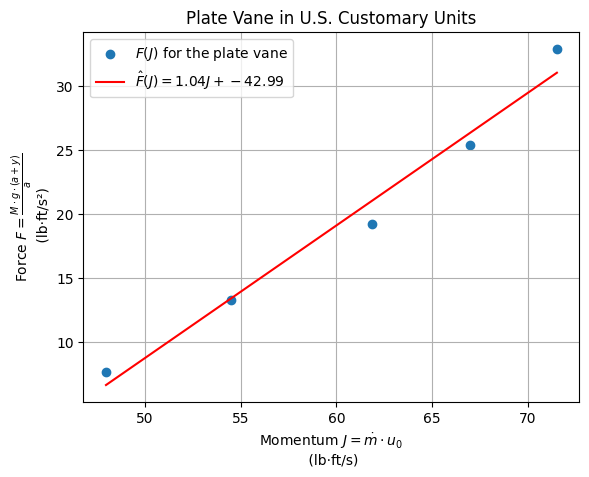


 - Results for Plate vane in U.S. Customary Units:
---------------------------------------------
  - The flow rates Q: [0.0212 0.0186 0.0162 0.0135 0.0103] cfs
  - The mass flow rates Qm: [0.00132 0.00116 0.00101 0.00084 0.00064] lb/s
  - Mean Velocity u: [25.039 22.024 19.191 16.005 12.191] ft/s
  - Deflected Velocity u_0: [24.891 21.856 18.998 15.772 11.884] ft/s
  - Momentum J: [32.892 25.405 19.242 13.323  7.646] lb·ft/s
  - Force F: [71.523 66.982 61.873 54.494 47.966] lb·ft/s²
  - Theoretical Force F: [31.042 26.341 21.053 13.414  6.657] lb·ft/s²
---------------------------------------------
  - Linear Regression Slope (K): 1
  - Linear Regression Intercept: -43
---------------------------------------------
  - Velocity Loss in percentage: [0.59 0.76 1.01 1.45 2.52]
---------------------------------------------




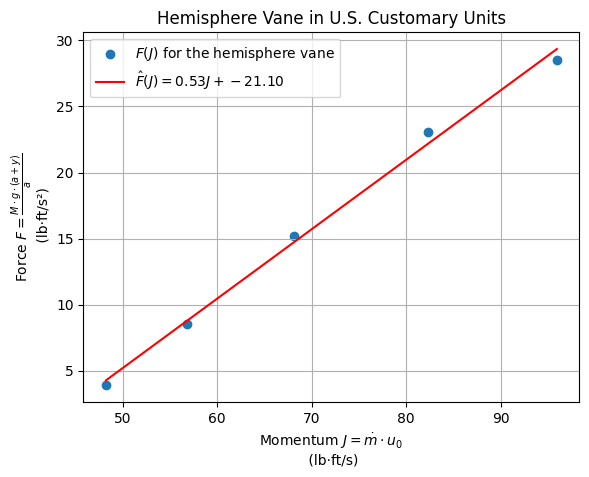


 - Results for Hemisphere vane in U.S. Customary Units:
---------------------------------------------
  - The flow rates Q: [0.0197 0.0177 0.0145 0.0109 0.0075] cfs
  - The mass flow rates Qm: [0.00123 0.00111 0.0009  0.00068 0.00047] lb/s
  - Mean Velocity u: [23.337 20.991 17.097 12.847  8.828] ft/s
  - Deflected Velocity u_0: [23.178 20.815 16.879 12.556  8.399] ft/s
  - Momentum J: [28.547 23.059 15.23   8.513  3.913] lb·ft/s
  - Force F: [95.932 82.309 68.118 56.765 48.25 ] lb·ft/s²
  - Theoretical Force F: [29.345 22.181 14.718  8.748  4.27 ] lb·ft/s²
---------------------------------------------
  - Linear Regression Slope (K): 0.53
  - Linear Regression Intercept: -21
---------------------------------------------
  - Velocity Loss in percentage: [0.68 0.84 1.27 2.27 4.86]
---------------------------------------------




In [30]:
# Execute the function for both configurations in US customary units
solution_us_customary(vol1, t1, y1, plate="plate")
solution_us_customary(vol2, t2, y2, plate="hemisphere")

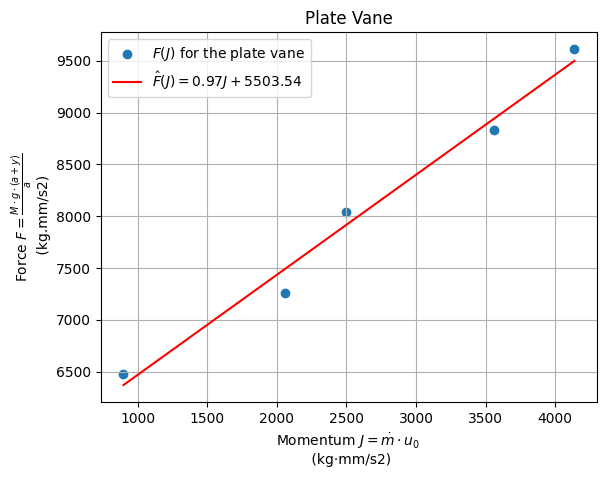


 - Results for Plate vane:
---------------------------------------------
  - The flow rates Q: [571973. 530973. 445434. 404858. 269421.] mm^3/s
  - The mass flow rates Qm: [0.572 0.531 0.445 0.405 0.269] kg/s
  - Mean Velocity u: [7283. 6761. 5671. 5155. 3430.] mm/s
  - Deflected Velocity u_0: [7235. 6710. 5611. 5088. 3329.] mm/s
  - Momentum J: [4138. 3563. 2499. 2060.  897.] kg·mm/s^2
  - Force F: [9614. 8829. 8044. 7259. 6475.] kg.mm/s^2
  - Theoretical Force F: [9499. 8943. 7917. 7492. 6369.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 0.97
  - Linear Regression Intercept: 5.5e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.65 0.75 1.07 1.3  2.96]
---------------------------------------------




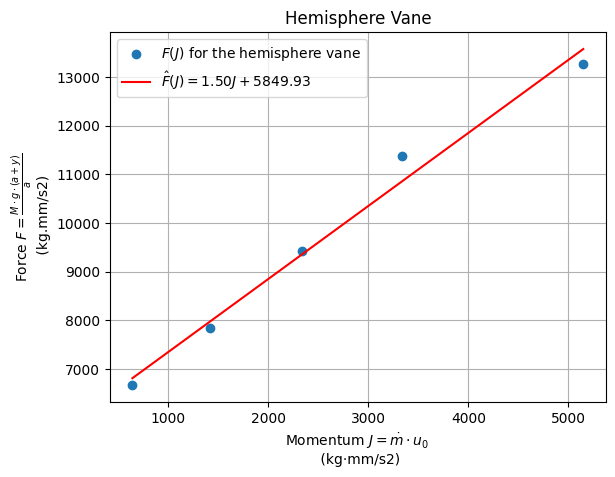


 - Results for Hemisphere vane:
---------------------------------------------
  - The flow rates Q: [637620. 513699. 431034. 337079. 229008.] mm^3/s
  - The mass flow rates Qm: [0.638 0.514 0.431 0.337 0.229] kg/s
  - Mean Velocity u: [8118. 6541. 5488. 4292. 2916.] mm/s
  - Deflected Velocity u_0: [8076. 6488. 5425. 4211. 2796.] mm/s
  - Momentum J: [5149. 3333. 2338. 1419.  640.] kg·mm/s^2
  - Force F: [13263. 11380.  9418.  7848.  6671.] kg.mm/s^2
  - Theoretical Force F: [13578. 10851.  9359.  7980.  6811.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 1.5
  - Linear Regression Intercept: 5.8e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.52 0.81 1.15 1.88 4.12]
---------------------------------------------




In [20]:
# Group 3

# Data for the flat plate
y1 = np.array([95, 75, 55, 35, 15])  # mm
vol1 = np.array([2000, 2000, 2000, 2000, 2000])  # mL
t1 = np.array([[3.33, 3.63, 3.53],
                [3.76, 3.73, 3.81],
                [4.36, 4.58, 4.53],
                [4.94, 4.99, 4.89],
                [7.53, 7.26, 7.48]])  # seconds

# Data for the hemispherical cup
y2 = np.array([188, 140, 90, 50, 20])  
vol2 = np.array([2000, 2000, 2000, 2000, 2000])
t2 = np.array([[2.99, 3.08, 3.34],
                [3.94, 4.16, 3.58],
                [4.58, 4.68, 4.66],
                [6.01, 5.91, 5.88],
                [8.91, 8.66, 8.63]])

# Execute the function for both configurations
solution(vol1, t1, y1, plate="plate")
solution(vol2, t2, y2, plate="hemisphere")

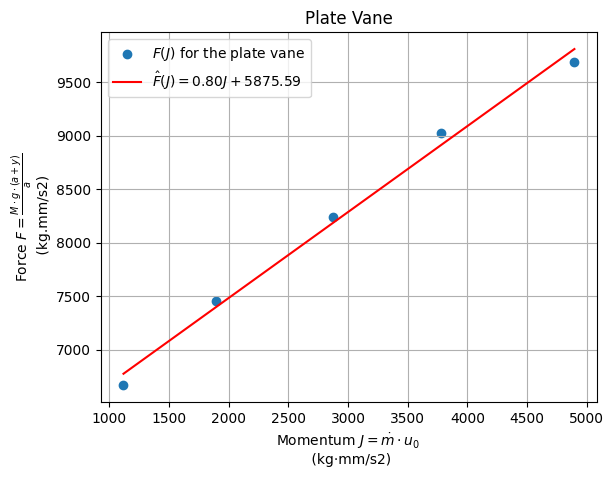


 - Results for Plate vane:
---------------------------------------------
  - The flow rates Q: [621762. 546448. 477707. 388853. 300300.] mm^3/s
  - The mass flow rates Qm: [0.622 0.546 0.478 0.389 0.3  ] kg/s
  - Mean Velocity u: [7917. 6958. 6082. 4951. 3824.] mm/s
  - Deflected Velocity u_0: [7873. 6908. 6026. 4881. 3733.] mm/s
  - Momentum J: [4895. 3775. 2878. 1898. 1121.] kg·mm/s^2
  - Force F: [9692. 9025. 8240. 7456. 6671.] kg.mm/s^2
  - Theoretical Force F: [9809. 8909. 8189. 7401. 6776.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 0.8
  - Linear Regression Intercept: 5.9e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.55 0.71 0.93 1.41 2.38]
---------------------------------------------




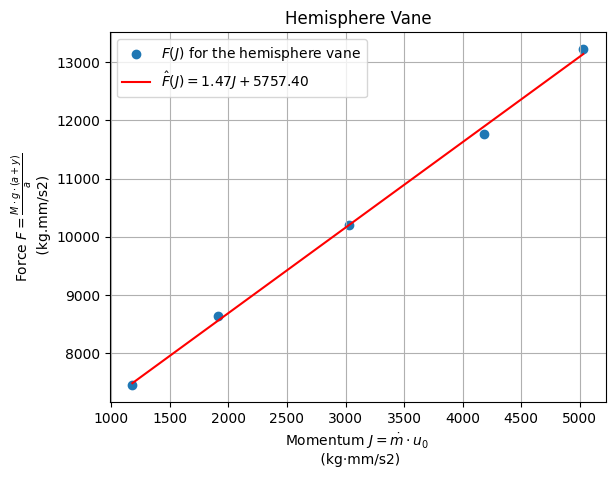


 - Results for Hemisphere vane:
---------------------------------------------
  - The flow rates Q: [630252. 575264. 490196. 389864. 307850.] mm^3/s
  - The mass flow rates Qm: [0.63  0.575 0.49  0.39  0.308] kg/s
  - Mean Velocity u: [8025. 7324. 6241. 4964. 3920.] mm/s
  - Deflected Velocity u_0: [7982. 7277. 6186. 4894. 3831.] mm/s
  - Momentum J: [5030. 4186. 3032. 1908. 1179.] kg·mm/s^2
  - Force F: [13224. 11772. 10202.  8633.  7456.] kg.mm/s^2
  - Theoretical Force F: [13137. 11899. 10206.  8557.  7488.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 1.5
  - Linear Regression Intercept: 5.8e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.53 0.64 0.89 1.4  2.26]
---------------------------------------------




In [23]:
# Group 2

# Data for the flat plate
y1 = np.array([97, 80, 60, 40, 20])  # mm
vol1 = np.array([2000, 2000, 2000, 2000, 2000])  # mL
t1 = np.array([[3.33, 3.14, 3.18],
                [3.61, 3.54, 3.83],
                [4.21, 4.05, 4.30],
                [5.10, 5.15, 5.18],
                [6.70, 6.73, 6.55]])  # seconds

# Data for the hemispherical cup
y2 = np.array([187, 150, 110, 70, 40])  
vol2 = np.array([2000, 2000, 2000, 2000, 2000])
t2 = np.array([[3.11, 3.18, 3.23],
                [3.35, 3.20, 3.88],
                [4.30, 4.13, 3.81],
                [5.30, 5.13, 4.96],
                [6.50, 6.43, 6.56]])

# Execute the function for both configurations
solution(vol1, t1, y1, plate="plate")
solution(vol2, t2, y2, plate="hemisphere")

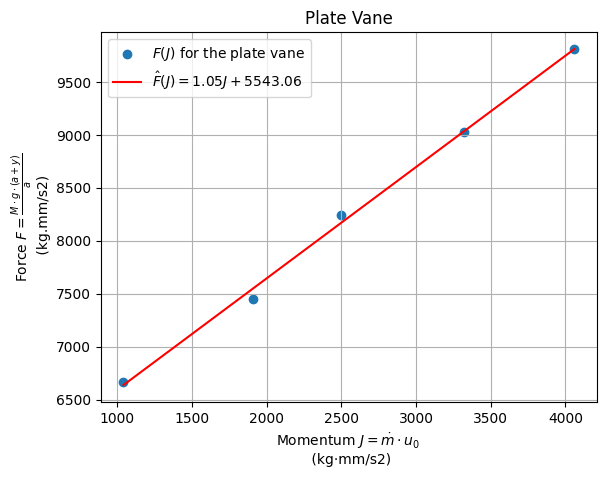


 - Results for Plate vane:
---------------------------------------------
  - The flow rates Q: [566572. 512821. 445434. 389864. 289855.] mm^3/s
  - The mass flow rates Qm: [0.567 0.513 0.445 0.39  0.29 ] kg/s
  - Mean Velocity u: [7214. 6529. 5671. 4964. 3691.] mm/s
  - Deflected Velocity u_0: [7166. 6477. 5611. 4894. 3596.] mm/s
  - Momentum J: [4060. 3321. 2499. 1908. 1042.] kg·mm/s^2
  - Force F: [9810. 9025. 8240. 7456. 6671.] kg.mm/s^2
  - Theoretical Force F: [9811. 9034. 8170. 7549. 6639.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 1.1
  - Linear Regression Intercept: 5.5e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.66 0.81 1.07 1.4  2.55]
---------------------------------------------




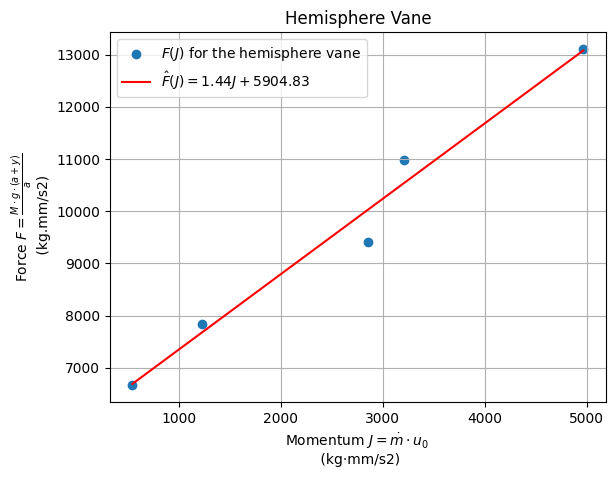


 - Results for Hemisphere vane:
---------------------------------------------
  - The flow rates Q: [626338. 504541. 476011. 314465. 212157.] mm^3/s
  - The mass flow rates Qm: [0.626 0.505 0.476 0.314 0.212] kg/s
  - Mean Velocity u: [7975. 6424. 6061. 4004. 2701.] mm/s
  - Deflected Velocity u_0: [7932. 6370. 6004. 3917. 2571.] mm/s
  - Momentum J: [4968. 3214. 2858. 1232.  545.] kg·mm/s^2
  - Force F: [13106. 10987.  9418.  7848.  6671.] kg.mm/s^2
  - Theoretical Force F: [13078. 10545. 10031.  7683.  6692.] kg.mm/s^2
---------------------------------------------
  - Linear Regression Slope (K): 1.4
  - Linear Regression Intercept: 5.9e+03
---------------------------------------------
  - Velocity Loss in percentage: [0.54 0.84 0.94 2.17 4.82]
---------------------------------------------




In [22]:
# Group 1

# Data for the flat plate
y1 = np.array([100, 80, 60, 40, 20])  # mm
vol1 = np.array([2000, 2000, 2000, 2000, 2000])  # mL
t1 = np.array([[3.53, 3.53, 3.53],
                [3.90, 3.90, 3.90],
                [4.49, 4.49, 4.49],
                [5.13, 5.13, 5.13],
                [6.90, 6.90, 6.90]])  # seconds

# Data for the hemispherical cup
y2 = np.array([184, 130, 90, 50, 20])  
vol2 = np.array([1966.7, 2033.3, 2016.7, 2000, 1966.7])
t2 = np.array([[3.14, 3.14, 3.14],
                [4.03, 4.03, 4.03],
                [4.57, 4.57, 3.57],
                [6.36, 6.36, 6.36],
                [9.27, 9.27, 9.27]])

# Execute the function for both configurations
solution(vol1, t1, y1, plate="plate")
solution(vol2, t2, y2, plate="hemisphere")

# Comments

- Group 1: Missing results for the hemispherical vane. Momentum and forces are incorrect. (82)
- Group 2: Almost everything was correct except the forces, which misled the plot (linear regression fitting)  (95)
- Group 3: Made mistakes in the computation of forces, which misled the plot. Also, the fit was incorrect. Was supposed to fit a linear curve on the observation (F(J)). (92)
- Group 4: The forces are incorrect. The plot needed to be split up (one for the plate and another for the hemispherical vane). Font size for the table and significant digits is not the best. (90)